In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt     
from PIL import Image
from tensorboardX import SummaryWriter
import numpy as np


/Users/adityadandwate/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class MaxPool(nn.Module):
    def __init__(self, pool_size):
        super(MaxPool, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)

    def forward(self, x):
        # print("x shape ", x.shape)
        return self.pool(x)


class Noise(nn.Module):
    def __init__(self, R_scale):
        super(Noise, self).__init__()
        self.mean = 0
        self.stdev = 1  # as defined in the paper

    def forward(self, d_coarse):
        noise = torch.rand_like(d_coarse)*self.stdev + self.mean
        d_noised = d_coarse + noise
        return d_noised


class IntervalThreshold(nn.Module):
    def __init__(self, m, n):
        super(IntervalThreshold, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_pool):
        threshold = (torch.max(d_pool) - torch.min(d_pool))/min(self.m, self.n)
        return threshold


class ReconGraph(nn.Module):
    def __init__(self, m, n):
        super(ReconGraph, self).__init__()
        self.m = m
        self.n = n

    def forward(self, d_noised, threshold):
        neighbours = set()
        labels = {}

        count = 0
        # print(self.m, self.n)
        for i in range(self.m):
            for j in range(self.n):

                labels[(j, i)] = count  # Labeling each pixel in (x, y) form
                count += 1
                for dy in range(-1, 2):
                    for dx in range(-1, 2):

                        if dx != 0 and dy != 0 and i+dy >= 0 and i+dy < self.m and j+dx >= 0 and j+dx < self.n:
                            if abs(d_noised[0][i+dy][j+dx] - d_noised[0][i][j]) <= threshold:
                                # (x, y) format
                                neighbours.add(((j, i), (j+dx, i+dy)))
        adjacency_matrix = torch.zeros(
            (self.m*self.n, self.m*self.n), dtype=bool)
        # print(adjacency_matrix.shape)

        for val in neighbours:
            N1, N2 = val  # in (x, y) form
            N1_x, N1_y = N1
            N2_x, N2_y = N2

            l1 = labels[(N1_x, N1_y)]
            l2 = labels[(N2_x, N2_y)]

            # Symmetric connections
            adjacency_matrix[l1, l2] = 1
            adjacency_matrix[l2, l1] = 1

        return adjacency_matrix


class GraphDropout(nn.Module):
    def __init__(self, p=0.5) -> None:
        super(GraphDropout, self).__init__()
        self.p = p

    def forward(self, adjacency_matrix):
        if self.train:
            mask = torch.empty_like(adjacency_matrix).bernoulli_(1 - self.p)
            output = adjacency_matrix * mask

        else:
            output = adjacency_matrix

        return output

class ExtractGraph(nn.Module):

    def __init__(self) -> None:
        super(ExtractGraph, self).__init__()

        self.maxpool = MaxPool(pool_size=2)
        self.noise = Noise(R_scale=0.4)  # From paper results
        self.dropout = GraphDropout(p=0.5)

    def forward(self, d_coarse, R_scale):

        # print('d_coarse: ', d_coarse.shape, 'type: ', d_coarse.dtype)
        d_pool = self.maxpool.forward(d_coarse)
        m = d_pool.shape[1]
        n = d_pool.shape[2]
        self.interval_threshold = IntervalThreshold(m, n)
        self.recon_graph = ReconGraph(m, n)

        print("pooled shape ", d_pool.shape)
        d_noise = self.noise.forward(d_pool)
        threshold = self.interval_threshold.forward(d_pool)
        adjacency_matrix = self.recon_graph.forward(d_noise, threshold)
        adjacency_matrix = self.dropout.forward(adjacency_matrix)

        return adjacency_matrix

class Encoder(nn.Module):

    def __init__(self) -> None:
        super(Encoder, self).__init__()
        encoder = models.resnet.resnet50(
            weights=models.ResNet50_Weights.DEFAULT)
        encoder = nn.Sequential(*list(encoder.children()))[:3]
        self.resnet_encoder = encoder

    def forward(self, x):
        self.resnet_encoder.eval()
        return self.resnet_encoder(x)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
rgb = Image.open("data/rgb/rgb_00002.jpg")
gt_depth = Image.open("data/gt_depth/sync_depth_00002.png")

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

rgb = transform(rgb)
gt_depth = transform(gt_depth)

print(rgb.shape, gt_depth.shape)

torch.Size([3, 480, 640]) torch.Size([1, 480, 640])


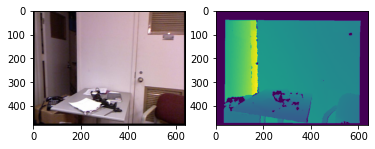

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(TF.to_pil_image(rgb.squeeze()))
axes[1].imshow(gt_depth.squeeze())

plt.show()

In [7]:
midas_model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", midas_model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if midas_model_type == "DPT_Large" or midas_model_type == "DPT_Hybrid":
    midas_transform = midas_transforms.dpt_transform
else:
    midas_transform = midas_transforms.small_transform

Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/adityadandwate/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /Users/adityadandwate/.cache/torch/hub/intel-isl_MiDaS_master


In [8]:
extractor = ExtractGraph()
encoder = Encoder()

In [9]:
# preprocessing for midas 
rgb_midas = rgb.permute(1, 2, 0)
rgb_midas = rgb_midas.numpy()

rgb_midas = midas_transform(rgb_midas).to(device)

print(rgb_midas.shape)

torch.Size([1, 3, 192, 256])


In [10]:
with torch.no_grad():
    depth_map = midas(rgb_midas)
    down_rgb = encoder.forward(rgb_midas)
    print(depth_map.shape)

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 192, 256])


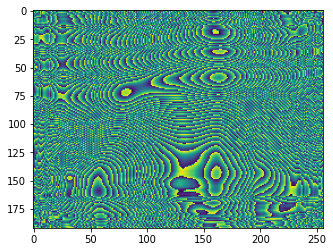

In [11]:
fig, axes = plt.subplots(1, 1)
depth_map = depth_map.cpu()
axes.imshow(TF.to_pil_image(depth_map.squeeze()))

plt.show()

In [23]:
transform_midas = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
img = cv2.imread("data/rgb/rgb_00002.jpg")
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = midas_transform(img).to(device)
print(input_batch.shape)

with torch.no_grad():
    prediction = midas(input_batch)

depth_map = prediction.cpu()
depth_map = depth_map.squeeze()
print("shape through midas ", depth_map.shape)

(480, 640, 3)
torch.Size([1, 3, 192, 256])
shape through midas  torch.Size([192, 256])


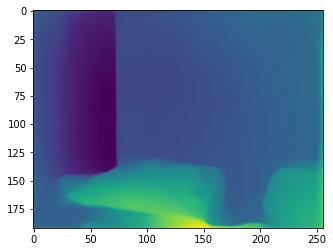

In [25]:
depth1 = depth_map.detach().numpy()
plt.imshow(depth1)
plt.show()

In [26]:
depth_map = depth_map.to(device).unsqueeze(0)
adj = extractor.forward(depth_map, 0.4)

pooled shape  torch.Size([1, 96, 128])


In [27]:
adj_np = np.array(adj.detach().cpu())

In [29]:
adj_np.shape

(12288, 12288)

In [17]:
from numba import cuda
import numpy as  np
import warnings
import OpenGL.GL as gl


In [ ]:
@cuda.jit
def compute_positions_kernel(positions, N, orig_m, orig_n):
    idx = cuda.grid(1)
    if idx < N:
        
        # orig_n is the number of cols
        positions[idx, 0] = idx // orig_n
        positions[idx, 1] = idx % orig_n

In [ ]:
N = adj_np.shape[0]

## the orig shape of the pooled depth image which is 
## converted to graph later

orig_m = 96 #hard coded value, change later
orig_n = 128 #hard coded value, change later

node_positions = np.zeros((N, 2), dtype=np.float32)
node_positions_gpu = cuda.to_device(node_positions)

block_size = 256
grid_size = (N + block_size - 1) // block_size
compute_positions_kernel[grid_size, block_size](node_positions_gpu, N, orig_m, orig_n)

# copy back to cpu
node_positions_gpu.copy_to_host(node_positions)
print(node_positions)